In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'life-expectancy-who:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F12603%2F17232%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240603%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240603T044211Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ac2f2e4b06cdacae00bd6c589d407c4413d2171d8e86e438be4b1fa84ead8c735814ac310619c8bb18c1ca1ad1d1adcd915d9293470ba83cc11d65f84905ad7a2f985db3674ca6b7a666bf6be8fb906338a97e5391d74e7bbc6eee4c3d92532be40521781e2e89f8ac6d7e5c43869c4898c3dfea419d2599fd80ba1752e83888505dc45cecb6298bc2b001dca12f4fc13a7c01fda79822e1bb905e17b80565d85f9e765eb5ca24cf8c8ebf459492606f9a6b2b008316044ad6958118e9ce8c5d7c5387d4eef3eb7c04392526a74ee2be3413c2de522bf9f7a858d0aab41b1e62938f61f91deb500abaa91aabce621311c6f1c838a52ab451f0d4f38227b0cb2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 121472 bytes downloaded
Downloaded and uncompressed: life-expectancy-who
Data source import complete.



# <p style="background-color:#8b7a5e;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:30px 30px;">Life expectancy Regression Using ANN</p>


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Import Needed Libraries</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model #for model visualization


from warnings import filterwarnings
filterwarnings('ignore')


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Read dataset into DataFrame</p>

In [ ]:
df=pd.read_csv('/kaggle/input/life-expectancy-who/Life Expectancy Data.csv')
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8



# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Features Metadata</p>

In [ ]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

|Feature | Description
|------|------------
|**Country** | countries has been collected from the same WHO data repository website
|**Year**|year 2013-2000
|**Status**|Status of country **Developing** or **Developed**
|**Life expectancy**|Life Expectancy in age **our target**
|**Adult Mortality**|Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
|**infant deaths**|Number of Infant Deaths per 1000 population
|**Alcohol**|Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
|**percentage expenditure**|Expenditure on health as a percentage of Gross Domestic Product per capita(%)
|**Hepatitis B**|Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
|**Measles**|Measles - number of reported cases per 1000 population
|**BMI**|Average Body Mass Index of entire population
|**under-five deaths**|Number of under-five deaths per 1000 population
|**Polio**|Polio (Pol3) immunization coverage among 1-year-olds (%)
|**Total expenditure**|General government expenditure on health as a percentage of total government expenditure (%)
|**Diphtheria**|Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
|**HIV/AIDS**|Deaths per 1 000 live births HIV/AIDS (0-4 years)
|**GDP**|Gross Domestic Product per capita (in USD)
|**Population**|Population of the country
|**thinness  1-19 years**|Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
|**thinness 5-9 years**|Prevalence of thinness among children for Age 5 to 9(%)
|**Income composition of resources**|Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
|**Schooling**|Number of years of Schooling(years)


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Exploratory Data Analysis</p>

# **<font color = #208AAE>DataFrame Shape</font>**

In [ ]:
#print number of rows and columns in the dataset

print("Number of Rows:",df.shape[0])
print("Number of Features:",df.shape[1])

Number of Rows: 2938
Number of Features: 22


# **<font color = #208AAE>DataFrame Info</font>**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

### **<font color = #208AAE>From previous result we can put in our mind that:</font>**

#### **<font color = #8b7a5e>Numerical Features are:</font>**

- 'Year'
- 'Life expectancy '
- 'Adult Mortality'
- 'infant deaths'
- 'Alcohol'
- 'percentage expenditure'
- 'Hepatitis B'
- 'Measles '
- ' BMI '
- 'under-five deaths '
- 'Polio'
- 'Total expenditure'
- 'Diphtheria '
- ' HIV/AIDS'
- 'GDP'
- 'Population'
- ' thinness  1-19 years'
- ' thinness 5-9 years'
- 'Income composition of resources'
- 'Schooling'

#### **<font color = #8b7a5e>Categorical Features (which need encoding later) are:</font>**

- 'Country'
- 'Status'

#### **<font color = #8b7a5e>Columns that have null values (which need handling later):</font>**

- 'Life expectancy '
- 'Adult Mortality'
- 'Alcohol'
- 'Hepatitis B'
- ' BMI '
- 'Polio'
- 'Total expenditure'
- 'Diphtheria '
- 'GDP'
- 'Population'
- ' thinness  1-19 years'
- ' thinness 5-9 years'
- 'Income composition of resources'
- 'Schooling'

#### **<font color = #8b7a5e>Target Feature:</font>**

- 'Life expectancy '

In [ ]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

# **<font color = #208AAE>Statistical Info for Numerical Features</font>**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life expectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
Adult Mortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
infant deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
Hepatitis B,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under-five deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03


# **<font color = #208AAE>Exploring Numerical Features</font>**

- 'Year'
- 'Life expectancy '
- 'Adult Mortality'
- 'infant deaths'
- 'Alcohol'
- 'percentage expenditure'
- 'Hepatitis B'
- 'Measles '
- ' BMI '
- 'under-five deaths '
- 'Polio'
- 'Total expenditure'
- 'Diphtheria '
- ' HIV/AIDS'
- 'GDP'
- 'Population'
- ' thinness  1-19 years'
- ' thinness 5-9 years'
- 'Income composition of resources'
- 'Schooling'

In [ ]:
# col =[- 'Year', 'Life expectancy ' ,'Adult Mortality','infant deaths', 'Alcohol','percentage expenditure','Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria '
# , ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']

cols = df.select_dtypes(include=['float64', 'int64']).columns

for i in cols:
    print(i, df[i].value_counts())
    print('-----------------------------------')

Year Year
2013    193
2015    183
2014    183
2012    183
2011    183
2010    183
2009    183
2008    183
2007    183
2006    183
2005    183
2004    183
2003    183
2002    183
2001    183
2000    183
Name: count, dtype: int64
-----------------------------------
Life expectancy  Life expectancy 
73.0    45
75.0    33
78.0    31
73.6    28
73.9    25
        ..
43.1     1
49.5     1
49.0     1
55.1     1
45.4     1
Name: count, Length: 362, dtype: int64
-----------------------------------
Adult Mortality Adult Mortality
12.0     34
14.0     30
16.0     29
11.0     25
138.0    25
         ..
666.0     1
675.0     1
654.0     1
633.0     1
665.0     1
Name: count, Length: 425, dtype: int64
-----------------------------------
infant deaths infant deaths
0      848
1      342
2      203
3      175
4       96
      ... 
171      1
201      1
215      1
253      1
110      1
Name: count, Length: 209, dtype: int64
-----------------------------------
Alcohol Alcohol
0.01    288
0.03     15
0.0

# **<font color = #208AAE>Exploring Categorical Features</font>**

#### **<font color = #8b7a5e>'Country' Feature</font>**

In [ ]:
df['Country'].value_counts()

Country
Afghanistan              16
Peru                     16
Nicaragua                16
Niger                    16
Nigeria                  16
                         ..
Niue                      1
San Marino                1
Nauru                     1
Saint Kitts and Nevis     1
Dominica                  1
Name: count, Length: 193, dtype: int64

#### **<font color = #8b7a5e>'Status' Feature</font>**

In [ ]:
df['Status'].value_counts()

Status
Developing    2426
Developed      512
Name: count, dtype: int64


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Data Cleaning</p>

# **<font color = #208AAE>Handling Missing Values</font>**
- 'Life expectancy '
- 'Adult Mortality'
- 'Alcohol'
- 'Hepatitis B'
- ' BMI '
- 'Polio'
- 'Total expenditure'
- 'Diphtheria '
- 'GDP'
- 'Population'
- ' thinness  1-19 years'
- ' thinness 5-9 years'
- 'Income composition of resources'
- 'Schooling'

In [ ]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

## **As the number of Missing Values is large I will use Imputing Method to fill null values with mean Value**

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)

df['Life expectancy ']=imputer.fit_transform(df[['Life expectancy ']])
df['Adult Mortality']=imputer.fit_transform(df[['Adult Mortality']])
df['Alcohol']=imputer.fit_transform(df[['Alcohol']])
df['Hepatitis B']=imputer.fit_transform(df[['Hepatitis B']])
df[' BMI ']=imputer.fit_transform(df[[' BMI ']])
df['Polio']=imputer.fit_transform(df[['Polio']])
df['Total expenditure']=imputer.fit_transform(df[['Total expenditure']])
df['Diphtheria ']=imputer.fit_transform(df[['Diphtheria ']])
df['GDP']=imputer.fit_transform(df[['GDP']])
df['Population']=imputer.fit_transform(df[['Population']])
df[' thinness  1-19 years']=imputer.fit_transform(df[[' thinness  1-19 years']])
df[' thinness 5-9 years']=imputer.fit_transform(df[[' thinness 5-9 years']])
df['Income composition of resources']=imputer.fit_transform(df[['Income composition of resources']])
df['Schooling']=imputer.fit_transform(df[['Schooling']])

In [ ]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

# **<font color = #208AAE>Handling Outliers</font>**

#### **<font color = #8b7a5e>First I will draw boxplot to check outliers</font>**

In [ ]:
# Loop through each column and create a box plot
for column in df.columns:
    fig = px.box(df, y=column, title=f'Box Plot for {column}')

    # Update layout to center the title and make it bold
    fig.update_layout(
        title=dict(text=f'<b>Box Plot for {column}</b>', x=0.5),
        boxmode='group'
    )

    fig.show()

#### **<font color = #8b7a5e>Second, dealing with outliers</font>**

In [ ]:
# Specify the list of columns you want to handle outliers for
cols_to_handle_outliers = [
    'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
    'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
    'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
    ' thinness  1-19 years', ' thinness 5-9 years',
    'Income composition of resources', 'Schooling'
]

# Perform outlier handling for each specified column
for col_name in cols_to_handle_outliers:
    # Calculate quartiles and IQR
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace outliers with the mean value of the column
    df[col_name] = np.where((df[col_name] > upper_bound) | (df[col_name] < lower_bound), np.mean(df[col_name]), df[col_name])


#### **<font color = #8b7a5e>Thirdly I will draw boxplot to check outliers after handling it</font>**

In [ ]:
for column in df.columns:
    fig = px.box(df, y=column, title=f'Box Plot for {column}')

    # Update layout to center the title and make it bold
    fig.update_layout(
        title=dict(text=f'<b>Box Plot for {column}</b>', x=0.5),
        boxmode='group'
    )

    fig.show()

#### **<font color = #8b7a5e>Much better 🥰</font>**


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Data Visualization</p>

In [ ]:
#using plotly draw count plot for df['Year']
fig = px.histogram(df, x='Year', color='Year', title='Count Plot for Year')

#update layout to center the title and make it bold
fig.update_layout(
    title=dict(text='<b>Count Plot for Year</b>', x=0.5)
)

fig.show()

In [ ]:
#using plotly draw line plot to show the trend of life expectancy over the years
fig = px.line(df.sort_values(by='Year'), x='Year', y='Life expectancy ',animation_frame='Country',animation_group='Year',color='Country', title='Trend of Life Expectancy Over the Years')

#update layout to center the title and make it bold
fig.update_layout(
    title=dict(text='<b>Trend of Life Expectancy Over the Years</b>', x=0.5)
)

fig.show()

In [ ]:
#using plotly draw count plot for df['Status'] and color each bar with different color
fig = px.histogram(df, x='Status', color='Status', title='Count Plot for Status of Country')

#update layout to center the title and make it bold
fig.update_layout(
    title=dict(text='<b>Count Plot for Status of Country</b>', x=0.5)
)

fig.show()

**Most of the data was collected in 2013**

## **Let's see range of Life expectancy for developing and developed Countries**

### **<font color = #8b7a5e>Developing</font>**

In [ ]:
# Filter DataFrame for 'Developing' status
developing_df = df[df['Status'] == 'Developing']

# Create a histogram
fig = px.histogram(developing_df, x='Life expectancy ', title="Life Expectancy of Developing Nations")
fig.update_layout(
    xaxis_title='',
    yaxis_title='Count of Ages',
    title_text='<b>Life Expectancy of Developing Countries</b>',
    title_x=0.5,  # Center title
)
fig.show()

> **We can say the range is from like 41 to 90 in Developing Countries**

### **<font color = #8b7a5e>Developed</font>**

In [ ]:
# Filter DataFrame for 'Developing' status
developing_df = df[df['Status'] == 'Developed']

# Create a histogram
fig = px.histogram(developing_df, x='Life expectancy ', title="Life Expectancy of Developing Nations")
fig.update_layout(
    xaxis_title='',
    yaxis_title='Count of Ages',
    title_text='<b>Life Expectancy of Developed Countries</b>',
    title_x=0.5,  # Center title
)
fig.show()

> **We can say the range is from like 70 to 90 in Developed Countries**

In [ ]:
#using plotly to visualize Average Adult Mortality of Developing and Developed Countries
fig = px.bar(df.groupby('Status', as_index=False).agg({'Adult Mortality':'mean'}),
             x='Status',
             y='Adult Mortality',
             color='Status',
             title='Average Adult Mortality of Developing and Developed Countries')

# Update layout to center the title
fig.update_layout(title_text='<b>Average Adult Mortality of Developing and Developed Countries</b>', title_x=0.5)

# Show the plot
fig.show()

In [ ]:
#using plotly to visualize Average Infant deaths of Developing and Developed Countries
fig = px.bar(df.groupby('Status', as_index=False).agg({'infant deaths':'mean'}),
             x='Status',
             y='infant deaths',
             color='Status',
             title='Average Infant deaths of Developing and Developed Countries')

# Update layout to center the title
fig.update_layout(title_text='<b>Average Infant deaths of Developing and Developed Countries</b>', title_x=0.5)

# Show the plot
fig.show()

> **Developing Countries have highest Adult Mortality and Infant deaths**

In [ ]:
#using plotly to visualize Average Alcohol consumption of Developing and Developed Countries
fig = px.bar(df.groupby('Status', as_index=False).agg({'Alcohol':'mean'}),
             x='Status',
             y='Alcohol',
             color='Status',
             title='Average Alcohol consumption of Developing and Developed Countries')

# Update layout to center the title
fig.update_layout(title_text='<b>Average Alcohol consumption of Developing and Developed Countries</b>', title_x=0.5)

# Show the plot
fig.show()

In [ ]:
#using plotly to visualize scatter ploy of Life expectancy vs Adult Mortality for countries over years
fig = px.scatter(df.sort_values(by='Year'), x='Life expectancy ', y='Adult Mortality',color='Country', size='Year', title='Life expectancy vs Adult Mortality for Countries over Years')

# Update layout to center the title
fig.update_layout(title_text='<b>Life expectancy vs Adult Mortality for Countries over Years</b>', title_x=0.5)

# Show the plot
fig.show()

In [ ]:
#using plotly to visualize scatter ploy of Life expectancy vs Infant deaths for Countries over Years
fig = px.scatter(df.sort_values(by='Year'), x='Life expectancy ', y='infant deaths',color='Country', size='Year', title='Life expectancy vs Infant deaths for Countries over Years')

# Update layout to center the title
fig.update_layout(title_text='<b>Life expectancy vs Infant deaths for Countries over Years</b>', title_x=0.5)

# Show the plot
fig.show()

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Create a correlation matrix for selected numeric columns
correlation_matrix = df[numeric_columns].corr()

# Plot heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                labels=dict(x='Columns', y='Columns', color='Correlation'),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='blues',
                title='Heatmap: Correlation Matrix of Numeric Columns')


fig.update_layout(title_text='<b> Heatmap: Correlation Matrix of Numeric Columns </b>', title_x=0.5 ,width=1200 ,height=1200)
fig.show()


# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Data Preprocessing</p>

# **<font color = #208AAE>Handling Categorical Features (encoding)</font>**

- 'Country'
- 'Status'

#### **<font color = #8b7a5e>Values Before Handling</font>**

In [ ]:
df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', "Côte d'Ivoire", 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo',
       'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia',
       'Georgia', 'Germany'

In [ ]:
df['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

In [ ]:
# Columns to apply label encoding
cols_to_encode = ['Country', 'Status']

# Apply label encoding to X
label_encoder_df = LabelEncoder()
for col in cols_to_encode:
    df[col] = label_encoder_df.fit_transform(df[col])

#### **<font color = #8b7a5e>Values After Handling</font>**

In [ ]:
df['Country'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  44,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
df['Status'].unique()

array([1, 0])

# **<font color = #208AAE>Splitting Features from Target</font>**

In [ ]:
X = df.drop('Life expectancy ', axis=1)
y = df['Life expectancy ']

In [ ]:
X

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,2015,1,263.000000,30.303948,0.01,71.279624,65.000000,2419.59224,19.1,...,82.550188,8.16,65.0,0.100000,584.259210,1.275338e+07,4.839704,4.870317,0.479,10.1
1,0,2014,1,271.000000,30.303948,0.01,73.523582,62.000000,492.00000,18.6,...,58.000000,8.18,62.0,0.100000,612.696514,3.275820e+05,4.839704,4.870317,0.476,10.0
2,0,2013,1,268.000000,30.303948,0.01,73.219243,64.000000,430.00000,18.1,...,62.000000,8.13,64.0,0.100000,631.744976,1.275338e+07,4.839704,4.870317,0.470,9.9
3,0,2012,1,272.000000,30.303948,0.01,78.184215,67.000000,2419.59224,17.6,...,67.000000,8.52,67.0,0.100000,669.959000,3.696958e+06,4.839704,4.870317,0.463,9.8
4,0,2011,1,275.000000,30.303948,0.01,7.097109,68.000000,2419.59224,17.2,...,68.000000,7.87,68.0,0.100000,63.537231,2.978599e+06,4.839704,4.870317,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,192,2004,1,164.796448,27.000000,4.36,0.000000,68.000000,31.00000,27.1,...,67.000000,7.13,65.0,1.742103,454.366654,1.277751e+07,9.400000,9.400000,0.407,9.2
2934,192,2003,1,164.796448,26.000000,4.06,0.000000,80.940461,2419.59224,26.7,...,82.550188,6.52,68.0,1.742103,453.351155,1.263390e+07,9.800000,9.900000,0.418,9.5
2935,192,2002,1,73.000000,25.000000,4.43,0.000000,73.000000,304.00000,26.3,...,73.000000,6.53,71.0,1.742103,57.348340,1.255250e+05,1.200000,1.300000,0.427,10.0
2936,192,2001,1,164.796448,25.000000,1.72,0.000000,76.000000,529.00000,25.9,...,76.000000,6.16,75.0,1.742103,548.587312,1.236616e+07,1.600000,1.700000,0.427,9.8


# **<font color = #208AAE>Data Scaling</font>**

In [ ]:
# Columns to scale
cols_to_scale = ['Country', 'Year', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

# Apply Min-Max scaling to the specified columns
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [ ]:
X

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.0,1.000000,1,0.578366,0.550981,0.000000,0.065265,0.150000,1.000000,0.209733,...,0.657296,0.686949,0.291667,0.000000,0.032752,0.408423,0.311823,0.309761,0.325180,0.360000
1,0.0,0.933333,1,0.596026,0.550981,0.000000,0.067320,0.075000,0.203340,0.203940,...,0.145833,0.688713,0.229167,0.000000,0.034350,0.010490,0.311823,0.309761,0.320863,0.353333
2,0.0,0.866667,1,0.589404,0.550981,0.000000,0.067041,0.125000,0.177716,0.198146,...,0.229167,0.684303,0.270833,0.000000,0.035421,0.408423,0.311823,0.309761,0.312230,0.346667
3,0.0,0.800000,1,0.598234,0.550981,0.000000,0.071587,0.200000,1.000000,0.192352,...,0.333333,0.718695,0.333333,0.000000,0.037570,0.118393,0.311823,0.309761,0.302158,0.340000
4,0.0,0.733333,1,0.604857,0.550981,0.000000,0.006498,0.225000,1.000000,0.187717,...,0.354167,0.661376,0.354167,0.000000,0.003477,0.095388,0.311823,0.309761,0.289209,0.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1.0,0.266667,1,0.361582,0.490909,0.262523,0.000000,0.225000,0.012812,0.302433,...,0.333333,0.596120,0.291667,0.965943,0.025449,0.409196,0.611842,0.603896,0.221583,0.300000
2934,1.0,0.200000,1,0.361582,0.472727,0.244418,0.000000,0.548512,1.000000,0.297798,...,0.657296,0.542328,0.354167,0.965943,0.025392,0.404596,0.638158,0.636364,0.237410,0.320000
2935,1.0,0.133333,1,0.158940,0.454545,0.266747,0.000000,0.350000,0.125641,0.293163,...,0.458333,0.543210,0.416667,0.965943,0.003130,0.004019,0.072368,0.077922,0.250360,0.353333
2936,1.0,0.066667,1,0.361582,0.454545,0.103199,0.000000,0.425000,0.218632,0.288528,...,0.520833,0.510582,0.500000,0.965943,0.030746,0.396022,0.098684,0.103896,0.250360,0.340000


# **<font color = #208AAE>Splitting data into Train Test</font>**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of Y_train is: {y_train.shape}\n")
print(f"Shape of X_test is: {X_test.shape}")
print(f"Shape of Y_test is: {y_test.shape}")

Shape of X_train is: (2350, 21)
Shape of Y_train is: (2350,)

Shape of X_test is: (588, 21)
Shape of Y_test is: (588,)



# <p style="background-color:#D2D4C8;font-family:ui-rounded;color:#5E4955;font-size:120%;text-align:center;border-radius:10px 10px;">Building ANN Model</p>

### **<font color = "purple">Model Structure</font>**

In [ ]:
model = Sequential([
        Dense(64, activation='relu', input_dim=21),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
])

### **<font color = "purple">Model Compiling</font>**

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mean_squared_error'])

### **<font color = "purple">Model Summary</font>**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1408      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9793 (38.25 KB)
Trainable params: 9793 (38.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **<font color = "purple">Model Visualization</font>**

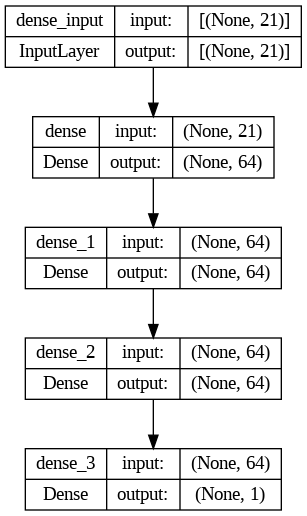

In [ ]:
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### **<font color = "purple">Model Fitting</font>**

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2)

Epoch 1/150
59/59 [==============================] - 5s 15ms/step - loss: 3881.6670 - mean_absolute_error: 60.6366 - mean_squared_error: 3881.6670 - val_loss: 869.8149 - val_mean_absolute_error: 27.4569 - val_mean_squared_error: 869.8149
Epoch 2/150
59/59 [==============================] - 0s 5ms/step - loss: 192.1178 - mean_absolute_error: 10.8265 - mean_squared_error: 192.1178 - val_loss: 102.3525 - val_mean_absolute_error: 8.2023 - val_mean_squared_error: 102.3525
Epoch 3/150
59/59 [==============================] - 0s 6ms/step - loss: 84.5208 - mean_absolute_error: 7.3639 - mean_squared_error: 84.5208 - val_loss: 78.8583 - val_mean_absolute_error: 7.0673 - val_mean_squared_error: 78.8583
Epoch 4/150
59/59 [==============================] - 0s 8ms/step - loss: 71.2480 - mean_absolute_error: 6.7779 - mean_squared_error: 71.2480 - val_loss: 71.4680 - val_mean_absolute_error: 6.7138 - val_mean_squared_error: 71.4680
Epoch 5/150
59/59 [==============================] - 1s 9ms/step - los

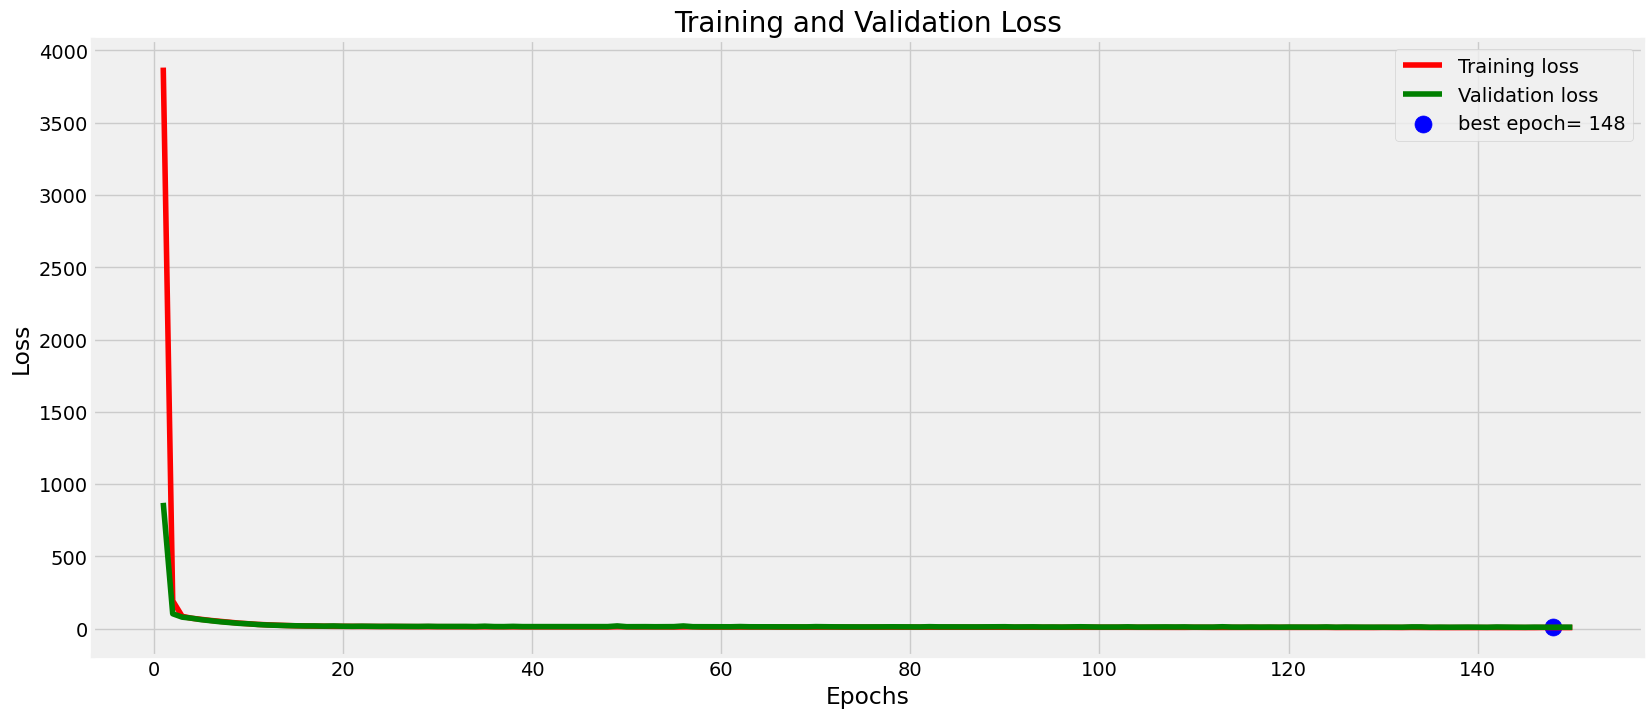

In [ ]:
# Define needed variables
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

Epochs = [i+1 for i in range(len(tr_loss))]
loss_label = f'best epoch= {str(index_loss + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#metrics=['mean_absolute_error','mean_squared_error']

mae = history.history['mean_absolute_error']

acc_loss_df = pd.DataFrame({"Mean Absolute error" : mae,
                            "Loss" : tr_loss,
                            "Epoch" : Epochs})

acc_loss_df.style.bar(color = '#84A9AC',
                      subset = ['Mean Absolute error','Loss'])

,Mean Absolute error,Loss,Epoch
0,60.636631,3881.666992,1
1,10.826511,192.117828,2
2,7.363900,84.520798,3
3,6.777931,71.248016,4
4,6.391988,63.754845,5
5,6.007220,56.152756,6
6,5.644242,49.595760,7
7,5.311103,43.711571,8
8,4.898290,37.629375,9
9,4.566919,32.989826,10


### **<font color = "purple">Prediction</font>**

In [ ]:
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 2ms/step


In [ ]:
R2 = r2_score(y_test, y_pred)
print("R2 Score=",R2 )

R2 Score= 0.9093902120116751
